In [4]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision
import sys 
import matplotlib.pyplot as plt 
import matplotlib_inline 
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
transform = T.Compose([
                        T.ToTensor(),
                        T.Resize(64),
                        T.Normalize(0.5,0.5)
])

dataset = torchvision.datasets.CIFAR10(root = './data', download = True, transform = transform)
data_loader = DataLoader(dataset, batch_size = 100, shuffle = True)

Files already downloaded and verified


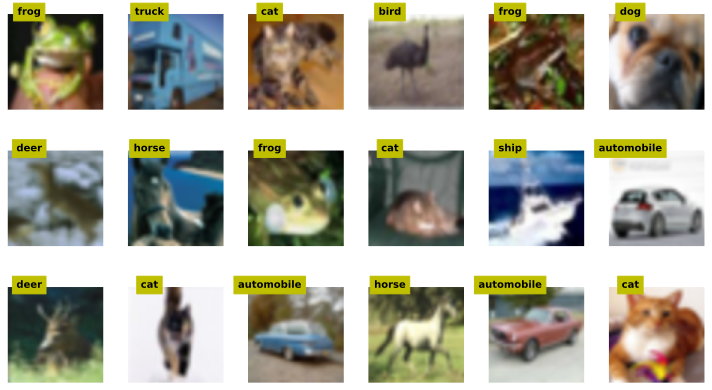

In [11]:
# view some images
# inspect a few random images

X,y = next(iter(data_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

    # extract that image
    pic = torch.squeeze(X.data[i]).permute(1,2,0)
    pic = pic/2 + .5 # undo normalization

    # and its label
    label = dataset.classes[y[i]]

    # and show!
    ax.imshow(pic,cmap='gray')
    ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [17]:
class discriminatorNet(nn.Module):
    
    def __init__(self):
        super(discriminatorNet, self).__init__()
        
        # convolutional layers (initial size = 64x64)
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias = False)  # size: 32x32
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias = False) # size: 16x16
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias = False) # size: 8x8
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias = False) # size: 4x4
        self.conv5 = nn.Conv2d(512, 1, 4, 2, 0, bias = False) # size: 1x1
        
        # batch norm 
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
    
    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x), .2)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), .2)
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x), .2)
        x = self.bn4(x)
        x = torch.sigmoid(self.conv5(x)).view(-1, 1)
        
        return x
        
dnet = discriminatorNet()
y = dnet(torch.randn(10, 1, 64, 64))
y.shape
        

RuntimeError: Given groups=1, weight of size [64, 3, 4, 4], expected input[10, 1, 64, 64] to have 3 channels, but got 1 channels instead

torch.Size([10, 3, 64, 64])


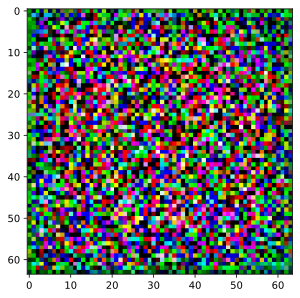

In [30]:
class generatorNet(nn.Module):
    
    def __init__(self):
        super(generatorNet, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 2, 0, bias = False) # 4x4
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False) # 8x8
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False) # 16x16
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False)  # 32x32
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False)    # 64x64
        
        # batch norm 
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = torch.tanh(self.conv5(x))
        
        return x
        
    
        
gnet = generatorNet() 
y = gnet(torch.randn(10, 100, 1, 1))
print(y.shape)
plt.imshow(y[0, :, :].squeeze().detach().numpy().transpose(1,2,0))

In [31]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr = .0002, betas = (.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr = .0002, betas = (.5, .999))


In [32]:
# training parameters 
numepochs = int(2500/len(data_loader))
batchsize = 100
losses = []
disDecs = []

for epochi in range(numepochs):
    
    for data, _ in data_loader:
    
    
        data = data.to(device)

        # create labels for real and fake images 
        real_labels = torch.ones(batchsize, 1).to(device)
        fake_labels = torch.zeros(batchsize, 1).to(device)

        ### Train the  Discriminator
        pred_real = dnet(data)
        d_loss_real = lossfun(pred_real, real_labels)

        # forward pass and loss for fake 
        fake_data = torch.randn(batchsize, 100, 1, 1).to(device)
        fake_images = gnet(fake_data)
        pred_fake = dnet(fake_images)
        d_loss_fake = lossfun(pred_fake, fake_labels)

        # collect loss 
        d_loss = d_loss_real + d_loss_fake 
    
        # back prop 
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()


        ### Train the generator 
        fake_images = gnet(torch.randn(batchsize, 100, 1, 1).to(device))
        pred_fake = dnet(fake_images)

        # compute loss 
        g_loss = lossfun(pred_fake, real_labels)

        # back prop 
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        pred_real = pred_real.cpu()
        pred_fake = pred_fake.cpu()
        losses.append([d_loss.item(), g_loss.item()])
        d1 = torch.mean((pred_real > .5).float()).detach()
        d2 = torch.mean((pred_fake > .5).float()).detach()
        disDecs.append([d1, d2])

    
        msg = f'Finished Epoch {epochi+1}/{numepochs}'
        sys.stdout.write('\r' + msg)
        


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Finished Epoch 5/5

In [33]:
losses = np.array(losses)
disDecs = np.array(disDecs)

In [34]:
def smooth(x, k = 15):
    return np.convolve(x,np.ones(k)/k,mode = 'same')

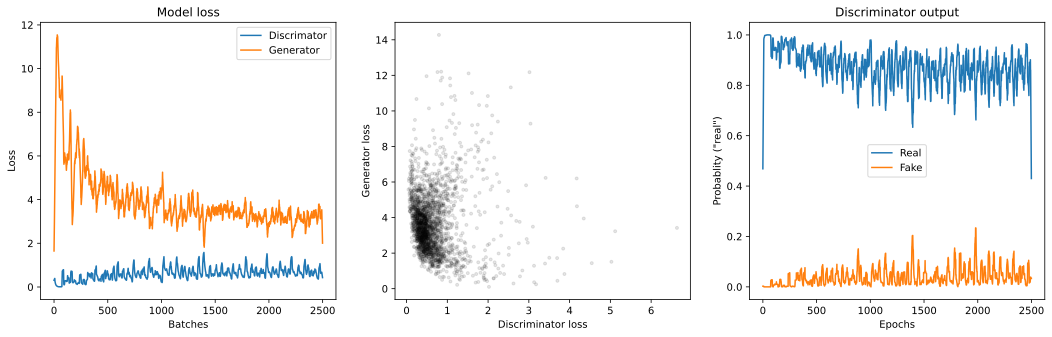

In [35]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0,2.5])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

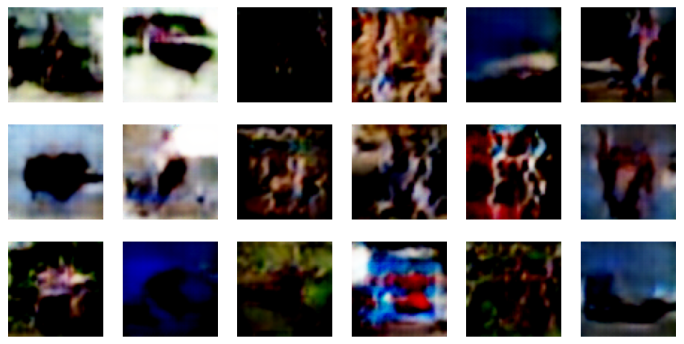

In [38]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,].detach().squeeze().permute(1,2,0))
    ax.axis('off')

plt.show()